In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import nbformat as nbf
import re

file_path = "/content/drive/MyDrive/Colab Notebooks/Reinforcement_Kovmir.ipynb"
with io.open(file_path, 'r', encoding='utf-8') as f:
  nb = nbf.read(f, 4)


word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        words = re.findall(r'\b\w+\b', cell.source)
        word_count += len(words)
print(word_count)


15072


<span style="color:DarkBlue;font-size:18px">Semesterabschließende schriftliche Ausarbeitung im Modul Deep Learning (WS2023)</span>

<span style="color:DarkBlue;font-size:32px">Reinforcement Learning am Beispiel eines Endlos-Scrollers mit Pygame</span>

<span style="color:DarkBlue;font-size:18px"> Bearbeitet von Frank Kovmir</span>

# Inhaltsverzeichnis





1. [Einleitung](#einleitung)<br>
2. [Technische Voraussetzungen](#theorie) <br>
3. [Einführung ins Reinforcement Learning](#einführung)<br>
4. [Entwicklung des Endlos-Scrollers](#entwicklung)<br>
5. [Erstellen des neuronalen Netzwerkes](#netzwerk)<br>
5. [Integration der KI in das Spiel](#integration)<br>
6. [Training des Modells](#training)<br>
7. [Evaluation und Test](#test)<br>
8. [Fazit](#fazit)<br>
9. [Literaturverzeichnis](#literatur)<br>
10. [Eigenständigkeitserklärung](#eigenständigkeitserklärung)

<a name="einleitung"></a>
## 1. Einleitung

Die vorliegende Arbeit beschäftigt sich mit der Entwicklung und dem Training eines Deep-Q-Networks (DQN) für ein selbst programmiertes Videospiel namens "Space Dodger". Das Ziel ist es, einen Agenten mittels Reinforcement Learning (RL) so zu trainieren, dass dieser selbstständig in der Lage ist, Hindernissen (in Form einer Kette von Asteroiden) in dem Spiel auszuweichen.

Im Rahmen der Arbeit wird im ersten Schritt das Spiel in einer Variante erstellt, in der es ein Mensch spielen kann. Im nächsten Schritt wird dann ein neuronales Netzwerk entwickelt und ein Trainingsskript geschrieben. Im Rahmen des Trainings soll das Netzwerk so trainiert werden, dass es auf Basis der aktuellen Spielumgebung eine qualifizierte Entscheidung über die zu ergreifenden Aktion treffen kann. Die optimale Strategie soll der Agent über die Vergabe von Belohnungen bzw. Bestrafungen im Rahmen von mehreren Spieliterationen (Episoden) erlernen. Schlussendlich wird das Spiel noch insofern modifiziert, dass es die notwendigen Informationen für das Training an den Agenten senden kann. Für das Training bzw. das neuronale Netz wird das Python Paket "Pytorch" genutzt, für den Aufbau des Spiels das Paket "Pygame".[1][2]

Es werden im Verlauf der Ausarbeitung insgesamt fünf Skripte erstellt:


1.   Ein "Human.py" Skript --> enthält unmodifizierten Spielecode
2.   Ein "Model.py" Skript --> enthält den Code für das DQN
3.   Ein "Main.py" Skript --> enthält den AI-modifizierten Spielecode
4.   Ein "Train.py" Skript --> enthält den Code um das Training des DQN zu starten
5.  Ein "Test.py" Skript --> enthält den Code um ein gespeichertes Model einzulesen und den Agenten spielen zu sehen.






<a name="theorie"></a>
## 2. Technische Voraussetzungen

Aufgrund von Limitierung in Jupyter Notebooks im Zusammenhang mit Pygame und dem Laden von lokalen Dateien, kann der Code nicht in einem funktionsfähigen Zustand im Notebook Format bereitgestellt werden. Stattdessen ist der gesamte Code als Repo auf Gitlab mittels dem unten zur Verfügung gestellten Link einsehbar.

Innerhalb des Notebooks wird zur Erklärung diverser Codestellen zwar dennoch Code eingefügt, dieser ist aber nicht lauffähig.

Für einen Test des bereits vorhandenen, über 1200 Episoden trainierten Modells, bzw. für das eigene Training ist es daher notwendig, das Repo zu klonen, die Pakete zu installieren (eine "requirements.txt" liegt dem Repo bei) und die Skripte "train.py" oder "test.py" laufen zu lassen.

Getestet wurde ausschließlich auf dem Betriebssystem Windows 11 in der 64-Bit Version.


Link zum Gitlab Repo:

https://github.com/frankkovmir/deeplearning






<a name="einführung"></a>
## 3. Einführung ins Reinforcement Learning

Beim RL handet es sich um eine Spezifizierung des Machine Learnings bei der es darum geht, dass ein KI-Agent lernt, sich in einer gegebenen Umgebung optimal zu verhalten. Der Agent führt Aktionen durch und erhält für diese entweder eine Belohnung oder Bestrafung, wobei die Maximierung der Belohnung durch den Agenten angestrebt werden sollte. Die Umgebung ist deterministisch, daher sind alle im Folgenden vorgestellten Gleichungen auch deterministisch formuliert, um die Komplexität zu reduzieren.[3]

Um das Lernen und die Entscheidungsfindung des Agenten zu strukturieren bzw. damit der Agent im Laufe der Zeit lernen kann, welche Zustände die höchste kumulative Belohnung liefern, wird der Markov-Entscheidungsprozess (Markov-Decision-Process, MDP) als mathematisches Modell genutzt. Dabei werden  folgende Schritte durchlaufen:


<br>

1.   Der Agent erhält einen Zustand (State, s0) von der Umgebung, welcher möglichst viele relevante Informationen beinhaltet. Im Kontext des "Space Dodger"-Spiels wäre jeder Zustand eine spezifische Konfiguration des Spielfeldes, d.h. es würde z.B. die Position des Raumschiff, die Position der Asteroiden und des Lochs, die Geschwindigkeit und das Level übergeben werden.
2.   Der Agent wählt eine Aktion (a0) auf Grundlage des Zustands (s0). In (mindestens) der ersten Iteration handelt es sich um eine rein zufällig gewählte Aktion, da dem Agenten die Konsequenzen seiner Handlungen noch nicht bekannt sind. In dem Spiel hat der Agent die Wahl zwischen zwei Aktionen, der Bewegung nach links, oder nach rechts.
3. Nach Durchführung der Aktion befindet sich der Agent in einem aktualisierten Zustand s1.
4. Nun erhält der Agent eine Belohnung oder eine Bestrafung (r1). Im vorliegenden Kontext wird das erfolgreiche Navigieren durch das Loch im Asteroidengürtel belohnt, und eine Kollision mit einem Asteroiden wird bestraft.[4]

<br>

In der Konsequenz bedeutet dies, dass der nächste Zustand eines KI-Agenten alleine vom letzten übergebenen Zustand abhängt und nicht aus einer Menge aller vorherigen Zustände.

Um das Konzept des RL weiter zu vertiefen, ist es wichtig, die übergeordneten Ansätze, nämlich modellbasiertes und modellfreies Lernen, zu unterscheiden. Diese beiden Ansätze definieren, wie ein RL-Agent aus seinen Erfahrungen lernt und Entscheidungen trifft.

Beim modellbasierten Lernen verfügt der Agent über ein Modell der Umgebung, welches ihm hilft, die Folgen seiner Aktionen vorherzusagen. Während ein Status lediglich eine Momentaufnahme des aktuellen Zustands der Umgebung aus der Sicht des Agenten darstellt (z.B. die Position des Raumschiffs und der Asteroiden) beinhaltet ein Modell der Umgebung von Natur aus ein Verständnis darüber, wie Aktionen Zustände verändern und welche Belohnungen mit diesen Änderungen verbunden sind.

Dieses Modell kann entweder vorab bekannt sein oder vom Agenten während des Lernprozesses erstellt werden. Ein solches Umgebungsmodell im RL umfasst typischerweise:


<br>

*   eine Übergangsfunktion, die die Wahrscheinlichkeit angibt, mit der der Agent vom aktuellen Zustand s1 in einen neuen Zustand s2 übergeht, wenn er Aktion a ausführt.
*   eine Belohnungsfunktion, die die Belohnung für den Übergang angiebt.
<br>
<br>

Im Gegensatz dazu hat der Agent beim modellfreien Lernen kein explizites Modell der Umgebung. Stattdessen lernt er direkt aus der Interaktion mit der Umgebung, ohne zu versuchen, ihre Dynamik zu verstehen oder vorherzusagen. Der Agent konzentriert sich darauf, basierend auf den erhaltenen Belohnungen herauszufinden, welche Aktionen in welchen Zuständen am vorteilhaftesten sind.[5]

Ein weiterer wichtiger Aspekt im RL ist der Unterschied zwischen On-Policy- und Off-Policy-Algorithmen. On-Policy-Algorithmen lernen den Wert von Aktionen basierend auf der derzeit verfolgten Politik (Strategie) des Agenten. Das bedeutet, dass der Agent seine aktuelle Politik basierend auf den Erfahrungen, die er unter dieser Politik macht, bewertet und verbessert. Im Gegensatz dazu lernen Off-Policy-Algorithmen den Wert von Aktionen basierend auf einer anderen Politik als der gerade ausgeführten.[6]

Das sogennante Q-Learning ist ein Beispiel für einen Off-Policy-Algorithmus, da es den Wert von Aktionen unabhängig von der aktuellen Politik des Agenten lernt. Der Agent kann also eine Politik verfolgen, die Exploration (Ausprobieren) priorisiert, während er gleichzeitig eine andere Politik bewertet und verbessert, die auf die Maximierung der Belohnungen abzielt.[7]
In der vorliegenden Arbeit wurde ein modellfreier, Off-Policy-Ansatz nach der Methode des Q-Learnings gewählt.

Im Rahmen des Q-Learnings wird zunächst eine Q-Tabelle erstellt, in der die Werte für alle möglichen Zustands-Aktions-Paare gespeichert werden. Diese Tabelle dient dazu, die vorteilhaftesten Aktionen in jedem Zustand zu schätzen. In einfachen Umgebungen, in denen die Anzahl der Zustände und Aktionen begrenzt ist, ist eine solche Tabelle praktikabel und vergleichsweise leicht verständlich.

In einem hypothetischen Spiel, in dem ein Agent sich zwischen zwei Aktionen wie z.B. links oder rechts bewegen entscheiden kann und es drei mögliche Zustände gibt, kann eine Q-Tabelle wie folgt aussehen:


<br>

| Zustand | Links | Rechts |
| :- | -: | :-: |
| Zustand 1 | 0.5 | 0.7
| Zustand 2 | 0.1 | -0.4
| Zustand 3 | 0.0 | 0.2

<br>

In dieser Tabelle repräsentiert jeder Eintrag den erwarteten Gesamtnutzen (die Q-Werte) für die jeweilige Aktion in jedem Zustand.

Mit zunehmender Komplexität der Umgebung wird jedoch die Verwendung einer Tabelle unpraktikabel. Stattdessen wird in komplexeren Umgebungen die Q-Tabelle durch eine sogenannte Q-Funktion abgelöst. Diese Funktion approximiert für jeden Zustand und jede Aktion den erwarteten Gesamtnutzen, also die Summe aller zukünftigen Belohnungen. Die Q-Funktion wird durch die Bellman-Gleichung  (welche ein Teil der Funktion ist) aktualisiert, was den Lernprozess des Agenten erst ermöglicht.[8]

Genauer ermöglicht die Bellmann-Gleichung die Verbindung des Wertes einer Aktion in einem bestimmten Zustand mit den Werten der besten Aktionen in den nachfolgenden Zuständen.

Insgesamt sieht die Aktualisierungsregel wie folgt aus:
<br>
<br>
Q(s,a)←Q(s,a)+α(r+γmaxₐ'Q(s,a')-Q(s,a))
<br>
<br>
Dabei sind die einzelnen Parameter wie folgt definiert:

<br>

*   Q(s,a): Der aktuelle Q-Wert für den Zustand s und die Aktion a.
*   α: Die Lernrate, welche als Parameter übergeben wird.
*   r: Die unmittelbare Belohnung für den Übergang in den neuen Zustand s' nach der Ausführung von Aktion a.
*   γ: Der Diskontierungsfaktor, der die Wichtigkeit zukünftiger Belohnungen angibt.
* maxₐ'Q(s',a'): Der maximale Q-Wert für den neuen Zustand s', der aus allen möglichen Aktionen a' im neuen Zustand resultiert.[9]

<br>

Eine der leistungsfähigsten Möglichkeiten die Q-Funktion in einer komplexen Umgebung einzusetzen stellen DQNs dar. Ein DQN nutzt ein neuronales Netzwerk, um die Q-Funktion zu approximieren. Dies ermöglicht es, kontinuierliche Zustandsräume und komplexe Muster zu verarbeiten und somit auch in komplexen Umgebungen mit einer großen Anzahl von Zuständen und Aktionen effektiv zu lernen.

Das neuronale Netzwerk im DQN nimmt den Zustand der Umgebung als Eingabe und gibt die Q-Werte für jede mögliche Aktion aus. Durch das Training des neuronalen Netzwerks lernt der DQN-Agent, die Q-Werte für Aktionen in verschiedenen Zuständen zu schätzen und die Politik kontinuierlich zu verbessern.[10]

Ein Schlüsselelement der DQN-Methode ist das Konzept des Experience Replay. Dabei speichert der Agent frühere Erfahrungen in einem Replay-Memory und verwendet zufällige Stichproben daraus, um das Netzwerk zu trainieren. Dies erhöht die Dateneffizienz und hilft, Korrelationen in der Abfolge von Beobachtungen zu reduzieren. Je nach verwendetem Replay-Memory lassen sich ein Standard Replay Memory und ein Prioritized Experience Replay unterscheiden. Bei ersterem werden die Erfahrungen in einem einfachen Puffer gespeichert und zufällige Stichproben werden für das Training genutzt. Hierbei hat jede gespeicherte Erfahrung dieselbe Wahrscheinlichkeit ausgewählt zu werden. Bei dem Priorisierungsansatz werden Erfahrungen hingegen basierend auf ihrer Priorität für das Training ausgewählt. Erfahrungen die zu einer größeren Veränderung des Modells führen, werden häufiger ausgewählt.[11]

Gemessen wird dies über den Unterschied zwischen dem Q-Wert des aktuellen Zustands und dem des nächsten Zustand. Wenn sich der Q-Wert des nächsten Zustands stark vom Q-Wert des aktuellen Zustands unterscheidet, bedeutet dies, dass die Wichtigkeit hoch ist, unabhängig davon, ob der Q-Wert im nächsten Zustand steigt oder sinkt. Diese Abweichung wird Temporal Difference Error (TD-Fehler) genannt.

Die Aktualisierungsregel im DQN folgt weiterhin der Bellman-Gleichung, jedoch werden Q-Werte hier durch das neuronale Netzwerk geschätzt. Die Q-Learning-Formel im Kontext eines DQNs sieht wie folgt aus:

<br>
Q(s,a)←Q(s,a)+α(r+γmaxₐ'Q(s',a';θ')-Q(s,a;θ))

<br>

Die neu eingeführten Variabeln θ und θ' repräsentieren die Parameter des neuronalen Netzwerks (Q-Netzwerk und Ziel-Q-Netzwerk). Es gibt also zwei Netzwerke, das Q-Netzwerk und das Zielnetzwerk (Target-Network). Während das Q-Netzwerk für die Auswahl der Aktionen des Agenten verantwortlich ist, dient das Zielnetzwerk als eine Art Schätzung für die "korrekte" Antwort. Es hilft dabei, die Güte der Entscheidungen des Q-Netzwerks zu bewerten.

Um im nächsten Schritt zu messen, wie gut das Q-Netzwerk diese Aktualisierungsregel befolgt, muss eine Verlustfunktion in den Trainingsprozess integriert werden. Diese Funktion misst den Unterschied zwischen den vom Netzwerk vorhergesagten Q-Werten und den Q-Werten, die basierend auf den Rückmeldungen des Zielnetzwerks (Target Network) und den erhaltenen Belohnungen als "korrekt" angesehen werden. Die Verlustfunktion wird oft (so auch in dieser Ausarbeitung) als Mean Squared Error (MSE) des Temporal Difference (TD) Fehlers definiert, es sind aber auch andere Ansätze möglich. Zur fortlaufenden Aktualisierung der Gewichte des Q-Netzwerks, wird die Backpropagation-Methode angewendet. Dadurch werden die Netzwerkparameter basierend auf dem berechneten Verlust optimiert.[12]

Innerhalb des DQN lassen sich verschiedene Typen unterscheiden. Neben dem in dieser Ausarbeitung genutzten klassischen DQN mit Standard Replay Memory gibt es auch die Möglichkeit ein Double DQN, Dueling DQN oder Prioritized Experience DQN zu nutzen, wobei jede Art spezifische Vor- und Nachteile aufweist.

Ein DQN mit Prioritized Memory kann beispielsweise zwar das Lernen durch die Bevorzugung und Wiederverwendung wichtiger Erfahrungen verbessern, kann aber auch zu einer Verzerrung durch Überanpassung führen. Ähnlich verhält es sich bei einem Double DQN. Hier werden zwei identische neuronale Netzmodelle verwendet, wobei das sekundäre Modell, welches eine Kopie der letzten Episode des primären Modells ist, für die Schätzung der Q-Werte genutzt wird, während das erste alleine aus der Erfahrung lernt. Neben der komplexeren Implementierung ist auch hier Overfitting ein potentielles Problem, wobei in bestimmten Umgebungen die Ergebnisse stabiler als beim regulären DQN sein können.[13]



<a name="entwicklung"></a>
## 4. Entwicklung des Endlos-Scrollers

Für die Entwicklung des Spiels soll das Paket "Pygame" den notwendigen Rahmen bieten. Im wesentlichen bietet das Paket die Möglichkeit, Bilder darzustellen und so miteinander zu verknüpfen, dass der Eindruck einer Animation entsteht. Weiterhin ist es mit dem Paket auch möglich, Sounds abzuspielen und Spielereingaben zu registrieren.

Zudem lässt sich über Pygame relativ einfach eine Kollisionserkennung über Rechtecke, oder (etwas umständlicher) über anliegende Masken erzielen. Diese Kollisionserkennung ist insbesondere dafür wichtig, um das Ende des Spiels zu registrieren und den Agenten (das neuronale Netz) entsprechend zu bestrafen. Da der Fokus der Ausarbeitung grundsätzlich auf den Deep Learning Aspekten liegen soll, wird der Pygame Code nur an zentralen Stellen näher erläutert.

Zuerst werden die genutzten Module importiert.

In [ ]:
import pygame
import random

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Das Zielszenario ist ein Spiel, bei dem sich mit konstanter Geschwindigkeit entlang der Y-Achse eine Kette von Asteroiden zum Spieler hin bewegt. Innerhalb der Kette gibt es ein Loch, durch welches der Spieler ein Raumschiff navigieren muss (Bewegung entlang der X-Achse), um das nächste Level zu erreichen. Sowohl die Position des Lochs, als auch die Größe sind randomisierte Parameter. Beim Übergang in ein neues Level erhöht sich die Geschwindigkeit der Asteroidenkette und das Ausweichen wird schwerer. Da die Geschwindigkeit des Raumschiffs aber konstant bleibt, gibt es ein natürliches Ende an dem Punkt, an dem die Bewegungsgeschwindigkeit des Raumschiffs nicht mehr ausreicht um das Loch zu erreichen. Diese natürliche Begrenzung ist wichtig, um die Episoden während des Trainings nicht überlang werden zu lassen. Insgesamt stehen also zwei Aktionen zur Verfügung, die Bewegung des Raumschiffs nach links, oder nach rechts.

Für die bessere Übersicht wird Klassenbasiert gearbeitet. Der gesamte Spielecode befindet sich in der Klasse "SpaceDodgerGame".

Um die Spielidee zu realisieren wird zuerst innerhalb des Konstruktors das Modul per pygame.init() initialisiert, wodurch im Hintergrund sämtliche notwendige Packete geladen werden. Weiterhin erfolgt im Konstruktor die Definition sämtlicher relevanter Startparameter (Spielgeschwindigkeit, Startlevel), sowie die Generierung der Objekte (Asteroiden, Raumschiff). Im Konstruktur werden auch Variablen zur Animation dieser Objekte und weitere spezifische Eigenschaften festgelegt. Der folgende Codeabschnitt zeigt den kompletten Code für den Konstruktor. Für die Asteroiden und das Schiff hätten grundsätzlich auch durch Pygame generierte Rechtecke verwendet werden können, für den Zweck der Überprüfung der Leistung des neuronalen Netzes hat sich der Autor aber dafür entschieden, mit Grafiken (sogenannten Sprites) zu arbeiten. Die Sprites liegen im Ordner "assets" und werden von dort eingelesen. Daher sollte die Ordnerstruktur nach Möglichkeit erhalten bleiben.

Da in einer früheren Version des Spiels noch mit mehreren Asteroidenketten pro Level gearbeitet wurde, finden sich zum Teil ggf. noch Relikte dieser alten Implementierung.


In [ ]:
class SpaceDodgerGame:
    def __init__(self):
        """
        Initialisiert das Spiel. Hier werden grundlegende Einstellungen, dh
        die Spielgeschwindigkeit, Level-Einstellungen und Grafikelemente (Asteroiden und Raumschiff-Sprites) geladen.
        """

        pygame.init()

        self.clock = pygame.time.Clock() # Framerate
        self.asteroids_per_level = 1  # Anzahl der Asteroidenketten pro Level (bleibt auch bei 1)
        self.current_level = 1  # Startlevel
        self.spawned_asteroids_count = 0  # Anzahl der bereits erschienenen Asteroiden

        # Lochposition und -größe für Asteroidenketten
        self.hole_position = 0
        self.hole_size = 0

        # Extrahieren einzelner Asteroiden-Sprites
        asteroid_sheet = pygame.image.load('assets/asteroids.png')
        asteroid_sprite_width, asteroid_sprite_height = asteroid_sheet.get_size()
        asteroid_sprite_width //= 8
        asteroid_sprite_height //= 8


        self.asteroid_sprites = []
        for row in range(8):
            for col in range(8):
                rect = pygame.Rect(col * asteroid_sprite_width, row * asteroid_sprite_height, asteroid_sprite_width, asteroid_sprite_height)
                asteroid_sprite = asteroid_sheet.subsurface(rect)
                self.asteroid_sprites.append(asteroid_sprite)

        # Laden der Raumschiff-Sprites
        sprite_sheet = pygame.image.load('assets/ship.png')
        sprite_width, sprite_height = sprite_sheet.get_size()
        sprite_width //= 5
        sprite_height //= 2
        scale_factor = 2
        self.spaceships = []

        for i in range(5):
            rect = pygame.Rect(i * sprite_width, 0, sprite_width, sprite_height)
            spaceship_sprite = sprite_sheet.subsurface(rect)
            scaled_sprite = pygame.transform.scale(spaceship_sprite,
                                                   (sprite_width * scale_factor, sprite_height * scale_factor))
            self.spaceships.append(scaled_sprite)

        # Erstellen von Masken für Kollisionserkennung
        self.spaceship_masks = [pygame.mask.from_surface(sprite) for sprite in self.spaceships]

        # Variablen für Raumschiffanimation
        self.current_spaceship_index = 0
        self.animation_frame_count = 0
        self.animation_speed = 5  # Niedrigere Werte bedeuten schnellere Animation

        # Spielfenster-Größe
        self.width, self.height = 288, 512
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Space Dodger")

        # Eigenschaften des Raumschiffs
        self.spaceship_width, self.spaceship_height = self.spaceships[0].get_size()
        self.spaceship_speed = 3 # Geschwindigkeit des Raumschiffs, weniger ist langsamer
        self.spaceship = None

        # Eigenschaften der Asteroiden (fixe Größe, Anfangsgeschwindigkeit)
        self.asteroid_size = 40
        self.asteroid_speed = 1
        self.asteroid_spawn_rate = 100 # ketten sollten zeitversetzt spawnen, falls es mehrere pro level gibt
        self.asteroids = []
        self.reset()

Nachdem der Konstruktur fertig ist und das Spielfenster, die Objekte, Kollisionsmasken und sämtliche weiteren relevanten Parameter definiert bzw. animiert sind, wird als nächstes eine Funktion implementiert, um den Spielzustand nach einer Kollision wiederherzustellen. Das Raumschiff wird dabei immer zentral auf der X-Achse positioniert, und weitere Parameter wie die Anzahl der Asteroiden und das Level wieder auf den Ursprung zurückgesetzt.

In [ ]:
    def reset(self):
        """
        Setzt nach einer Kollision das Spiel zurück, indem es das Raumschiff und die Asteroiden neu positioniert und das Level zurücksetzt.
        """
        self.spaceship = pygame.Rect(self.width // 2 - self.spaceship_width // 2,
                                     self.height - self.spaceship_height - 10,
                                     self.spaceship_width, self.spaceship_height)
        self.asteroids = []
        self.frame_count = 0
        self.spaceship_mask = self.spaceship_masks[0]
        self.current_level = 1
        self.spawned_asteroids_count = 0
        self.asteroid_speed = 1

Um den visuellen Eindruck eines animierten Raumschiffs zu erzeugen, wird noch eine Methode implementiert, welche alle paar Frames durch die Sprites des Raumschiffs iteriert und den Index des aktuellen Raumschiff-Sprites ändert.

In [ ]:
    def update_spaceship_animation(self):
        """
        Aktualisiert die Animation des Raumschiffs.
        """
        self.animation_frame_count += 1
        if self.animation_frame_count >= self.animation_speed:
            self.animation_frame_count = 0
            self.current_spaceship_index = (self.current_spaceship_index + 1) % len(self.spaceships)
            self.spaceship_mask = self.spaceship_masks[self.current_spaceship_index]

Im nächsten Schritt wird die eigentliche Asteroidenkette mit dem entsprechenden Loch generiert, durch welches das Raumschiff hindurchfliegen muss. Der Prozess beginnt mit der Festlegung des Bereichs, in dem diese Lücke erscheinen kann, wobei darauf geachtet wird, dass sie nicht zu nahe an der aktuellen Position des Raumschiffs platziert wird. Um dies zu erreichen, definiert die Methode eine Ausschlusszone rund um das Raumschiff, die verhindert, dass die Lücke direkt an der Stelle erscheint, an der sich das Raumschiff befindet. Dies hat den Hintergrund, dass das Training sonst ggf. nicht effektiv wäre - denn wenn sich das Raumschiff nicht bewegen muss und quasi "automatisch" durch das Loch fliegt, gibt es keine Herausforderung und keine Strategie die der Agent erlernen kann.

Anschließend teilt die Methode den möglichen Bereich für die Lücke in zwei Teile: links und rechts von dieser Ausschlusszone. Dies stellt sicher, dass die Lücke in einem sicheren Abstand vom Raumschiff erscheint. Die Methode überprüft dann, ob es gültige Positionen für die Lücke gibt.

Sobald ein gültiger Bereich festgelegt ist, wählt die Methode zufällig aus, ob die Lücke links oder rechts von der Ausschlusszone erscheinen soll. Die Größe dieser Lücke wird ebenfalls, innerhalb eines vordefinierten Rahmens, zufällig bestimmt.

Nachdem die Position und Größe der Lücke festgelegt sind, beginnt die Methode mit der Erzeugung der Asteroiden. Sie platziert Asteroiden entlang der gesamten Breite des Spielfelds, mit Ausnahme des Bereichs, der als Lücke definiert wurde. Jeder Asteroid wird aus einer vorher festgelegten Liste von Sprites zufällig ausgewählt, skaliert und dann positioniert.

Abschließend aktualisiert die Methode die gespeicherten Werte für die Position und Größe der Lücke. Diese Informationen sind wichtig für die Spiellogik, da sie bestimmen, wo und wie die nächste Reihe von Asteroiden erscheinen wird.

In [ ]:
    def spawn_asteroid_chain(self):
        """
        Erzeugt eine Kette von Asteroiden mit einer Lücke, durch die das Raumschiff hindurchfliegen kann.
        """
        # Festlegen des Bereichs, in dem das Loch erscheinen kann, um die Startposition des Raumschiffs zu vermeiden
        min_x = 0
        max_x = self.width - self.asteroid_size * 3

        # Bestimmung der aktuellen Position des Raumschiffs
        spaceship_x_center = self.spaceship.x + self.spaceship_width // 2

        # Definieren eines Bereichs um das Raumschiff, in dem das Loch nicht erzeugt werden sollt
        exclusion_zone = self.spaceship_width * 2

        # Aufteilen der möglichen Lochpositionen in zwei Bereiche, um die Ausschlusszone zu vermeiden
        left_range = [x for x in range(min_x, spaceship_x_center - exclusion_zone) if
                      x + self.asteroid_size * 3 <= max_x]
        right_range = [x for x in range(spaceship_x_center + exclusion_zone, max_x) if x >= min_x]

        # Überprüfen, ob gültige Positionen in den Bereichen vorhanden sind
        if not left_range and not right_range:
            print("No valid positions for the hole. Adjust game parameters.")
            return

        # Zufällige Auswahl, ob das Loch links oder rechts von der Ausschlusszone sein wird
        if left_range and (not right_range or random.random() > 0.5):
            hole_position = random.choice(left_range)
        else:
            hole_position = random.choice(right_range)

        # Bestimmen der Größe des Lochs
        hole_size = random.randint(self.asteroid_size * 2, self.asteroid_size * 3)

        # Erzeugen der Asteroiden, wobei eine Lücke an der gewählten Position gelassen wird
        for x in range(0, self.width, self.asteroid_size):
            if not hole_position <= x < hole_position + hole_size:
                asteroid_sprite = random.choice(self.asteroid_sprites)
                scaled_sprite = pygame.transform.scale(asteroid_sprite, (self.asteroid_size, self.asteroid_size))
                self.asteroids.append(
                    [scaled_sprite, pygame.Rect(x, 0, self.asteroid_size, self.asteroid_size), self.asteroid_speed])

        # Aktualisieren der Lochposition und -größe
        self.hole_position = hole_position
        self.hole_size = hole_size

Darauf folgt die "run" - Methode als zentraler Bestandteil des Spielecodes. Diese Methode startet die Hauptschleife, welche kontinuierlich läuft und den Rahmen für sämtliche Bilder und Aktionen bietet. Die Schleife ist verantwortlich für die ständige Aktualisierung des Spielzustands und reagiert kontinuierlich auf Benutzereingaben und andere Ereignisse.

Zu Beginn wird die Variable "running" auf True gesetzt. Innerhalb der While-Schleife wird dann über "pygame.key" und die noch folgende Funktion "process_input" kontinuierlich geprüft, ob es Inputs (Tastendrücke) vom Spieler gibt. Außerdem wird hier die Framerate des Spiels definiert (60) und alle Spielelemente, wie das Raumschiff und die Asteroiden, werden über "render()" auf den Bildschirm gezeichnet.

In [ ]:
    def run(self):
        """
        Startet die main loop des Spiels.
        """
        running = True
        while running:
            self.screen.fill((0, 0, 0))

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            keys = pygame.key.get_pressed()
            self.process_input(keys)
            self.update_spaceship_animation()
            self.render()
            self.clock.tick(60)

            pygame.display.update()
        pygame.quit()


Daran schließt die soeben erwähnte "process_input" Methode an. Diese ist zuständig für die Verarbeitung der Benutzereingaben und spielt die zentrale Rolle für die Steuerung des Raumschiffs im Spiel. Abhängig von der gedrückten Taste wird eine Aktion ausgeführt, wobei folgendes gilt:

Die linke Pfeiltaste bewegt bei Tastendruck das Raumschiff nach links, sofern sich das Raumschiff nicht bereits am äußersten Rand befindet. Entsprecht bewegt die rechte Pfeiltaste das Raumschiff gleichgeartet nach rechts.

Die Bewegung erfolgt dabei in Abhängigkeit des Wertes, welcher der Variable self.spaceship_speed zugeordnet ist. Weiterhin überprüft die Methode, ob bereits eine Asteroidenkette im Level generiert wurde und falls das nicht der Fall ist, wird eine generiert.

Auch die Erkennung der Kollision zwischen Raumschiff und Asteroiden, sowie die Entfernung von Asteroiden welche den unteren Bildschirmrand passiert haben wird über diese Funktion gesteuert.

In [ ]:
    def process_input(self, keys):
        """
        Verarbeitet Benutzereingaben.
        """
        if keys[pygame.K_LEFT] and self.spaceship.x > 0:
            self.spaceship.x -= min(self.spaceship_speed, self.spaceship.x)
        elif keys[pygame.K_RIGHT] and self.spaceship.x < self.width - self.spaceship_width:
            self.spaceship.x += min(self.spaceship_speed, self.width - self.spaceship_width - self.spaceship.x)

        # Steuerung des Raumschiffs nach links oder rechts
        if self.spawned_asteroids_count < self.asteroids_per_level:
            if self.frame_count % self.asteroid_spawn_rate == 0:
                self.spawn_asteroid_chain()
                self.spawned_asteroids_count += 1

        # Kollisionscheck
        for asteroid in self.asteroids:
            asteroid_sprite, asteroid_rect, _ = asteroid
            asteroid_rect.y += self.asteroid_speed
            new_y = asteroid_rect.y

            asteroid_mask = pygame.mask.from_surface(asteroid_sprite)
            offset_x = asteroid_rect.x - self.spaceship.x
            offset_y = new_y - self.spaceship.y

            if self.spaceship_mask.overlap(asteroid_mask, (offset_x, offset_y)):
                self.reset()
                break

        # Asteroiden entfernen die den Rand verlassen
        self.asteroids = [asteroid for asteroid in self.asteroids if asteroid[1].y <= self.height]

        if len(self.asteroids) == 0 and self.spawned_asteroids_count >= self.asteroids_per_level:
            self.prepare_next_level()

Sofern der Spieler erfolgreich durch das Loch navigiert (d.h. der Asteroidenkette ausweicht), ist das Level beendet und das nächste Level startet. Die Geschwindigkeit der Asteroiden erhöht sich. Dies ist in der Funktion "prepare_next_level" definiert.

In [ ]:
    def prepare_next_level(self):
        """
        Uebergang ins naechste Level.
        """
        self.current_level += 1
        self.asteroid_speed += 0.5
        self.spawn_asteroid_chain()
        self.spawned_asteroids_count = 0
        self.asteroids = []
        print(f"Nächstes Level: {self.current_level}")

Die gesamten Spielelemente werden wie zuvor erwähnt durch die render Methode auf den Buldschirm gezeichnet. Dazu gehört neben Asteroiden und Raumschiff auch die Anzeige des aktuellen Levels.

In [ ]:
    def render(self):
        """
        Zeichnet alle Spielelemente auf dem Bildschirm. Dies umfasst das Raumschiff, die Asteroiden und die Spielinformationen wie das aktuelle Level.
        """
        self.screen.fill((0, 0, 0))

        current_spaceship = self.spaceships[self.current_spaceship_index]
        self.screen.blit(current_spaceship, self.spaceship.topleft)

        for asteroid in self.asteroids:
            self.screen.blit(asteroid[0], asteroid[1].topleft)

        font = pygame.font.Font(None, 36)
        level_text = font.render(f"Level: {self.current_level}", True, (255, 255, 255))
        self.clock.tick(60)
        self.screen.blit(level_text, (10, 10))


if __name__ == "__main__":
    game = SpaceDodgerGame()
    game.run()

Damit ist die "menschliche" Version des Spiels unter dem Namen "human.py" abgeschlossen.



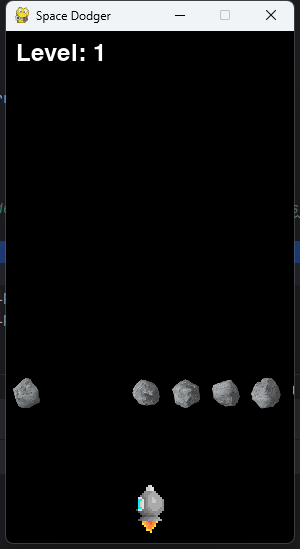

<a name="netzwerk"></a>
## 5. Erstellen des Neuronalen Netzwerkes


In diesem Kapitel soll das Neuronale Netzwerkmodell und somit das "Gehirn" des DQN zur Approximierung der Q-Funktion erstellt werden.

Dafür wird ein neues Skript namens model.py angelegt, in dem zunächst der Import der PyTorch-Module erfolgt.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

Die Klasse "nn" enthält Modul-Klassen wie 'Linear' für vollständig verbundene Schichten, während functional z.B. Aktivierungsfunktionen wie Rectified Linear Unit (ReLU) bereitstellt.

In einem DQN gibt es im Wesentlichen drei Arten von Schichten: Eingabe-, versteckte (oder verborgene) und Ausgabeschichten. Die Eingabeschicht nimmt Informationen aus der Umgebung auf, die verborgenen Schichten verarbeiten diese Informationen weiter und die Ausgabeschicht liefert das Ergebnis des Netzwerks,zum Beispiel eine Entscheidung oder eine Vorhersage.[14]

Ein wichtiger Bestandteil dieser Schichten sind die sogenannten Aktivierungsfunktionen. Diese Funktionen bestimmen, ob ein Neuron "aktiviert" oder "feuert". In einem neuronalen Netzwerk besteht jedes Neuron aus Eingaben, die gewichtet, summiert und dann durch eine Aktivierungsfunktion geleitet werden. Diese Aktivierungsfunktion entscheidet darüber, ob und wie stark ein Neuron "aktiviert" wird, das heißt, ob es ein Signal an die nächste Schicht im Netzwerk weitergibt. Man kann sich ein Neuron vorstellen wie eine Art Entscheidungsträger, der basierend auf seinen Eingaben entscheidet, ob er ein Signal "feuert" (verwirft) oder "aktiviert" (weiterleitet).[15]

Eine gängige Aktivierungsfunktion ist die ReLU. Sie funktioniert wie ein Filter, der basierend darauf wie relevant bestimmte Signale für die erlernte Aufgabe sind, entweder durchlässig oder hemmend für diese Signale ist.

ReLU ist durch die Formel f(x)=max(0,x) definiert. Diese Funktion setzt alle negativen Eingabewerte auf null und lässt alle positiven Werte unverändert. In der Praxis bedeutet dies, dass ein Neuron nur dann aktiviert wird und ein Signal weiterleitet, wenn seine gewichtete Eingabesumme positiv ist. Ist die Eingabesumme negativ, wird das Neuron nicht aktiviert und sendet auch kein Signal weiter ("feuern").[16]

Durch das Nullsetzen negativer Werte trägt die ReLU-Aktivierungsfunktion zur Nichtlinearität des Netzwerks bei. Das ist insbesondere deshalb wichtig, weil viele Probleme, die  neuronale Netzwerke zu lösen versuchen, einen nicht-linearen Charakter haben.

In dem Konstruktor des DQN werden die verschiedenen Schichten des Netzwerks definiert. Hier wird die Größe des Eingabevektors (input_size) und die Größe des Ausgabevektors (output_size) festgelegt. Die Eingabegröße entspricht der Anzahl der Merkmale in den Daten, die das Netzwerk erhält, und die Ausgabegröße entspricht der Anzahl der möglichen Aktionen, die das Netzwerk treffen kann. In diesem Fall hat das Netzwerk drei vollständig verbundene Schichten. Die erste Schicht (fc1) nimmt die Eingabedaten auf und transformiert sie in einen 128-dimensionalen Raum. Die zweite Schicht (fc2) transformiert diesen 128-dimensionalen Raum erneut, und die dritte Schicht (fc3) reduziert schließlich diese Informationen auf die Größe des Ausgabevektors.

Die Anzahl der Neuronen innerhalb der Schichten des neuronalen Netzwerkes ist ein Parameter, der abhängig von verschiedenen Faktoren gewählt werden muss. Komplexe Aufgaben, die eine tiefere und feinere Verarbeitung der Eingabedaten erfordern, können von mehr Neuronen profitieren. Gleichzeitig muss aber ein Netzwerk mit einer großen Anzahl von Neuronen mehr Trainingsdaten bzw. Trainingsepisoden durchlaufen, um eine Überanpassung (Overfitting) zu vermeiden. Zudem erhöht sich auch die Anforderung an die Rechnerleistung und die Trainingszeit steigt.

Für das Space Dodger Spiel wurde mit einer kleinen Anzahl von Neuronen bgegonnen (40) und diese Anzahl wurde dann iterativ in einem Testszenario von jeweils 100 Episoden auf bis auf 128 Neuronen hochgeschraubt. Mehr Neuronen haben keine signifikante Verbesserung in der Performance gezeigt.

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        """
        Konstruktor der Netzwerk-Klasse.

        Parameter:
        - input_size: Die Größe des Eingabevektors, was der ANzahl der Merkmale entspricht, die  das Netzwerk erhält (5, siehe get_state methode in main.py).
        - output_size: Die Größe des Ausgabevektors, was der Anzahl der Aktionen entspricht, die das Netzwerk treffen kann (zwei, links/rechts).

        Das Netzwerk besteht aus drei vollständig verbundenen Schichten (fully connected layers).
        """

        super(DeepQNetwork, self).__init__()


        # Definieren der ersten vollständig verbundenen Schicht (fc1)
        # von der Eingabeschicht zur ersten verborgenen Schicht mit 128 Neuronen
        self.fc1 = nn.Linear(input_size, 128)

        # Definieren der zweiten vollständig verbundenen Schicht (fc2)
        # von der ersten zur zweiten verborgenen Schicht, ebenfalls mit 128 Neuronen
        self.fc2 = nn.Linear(128, 128)

        # Definieren der dritten vollständig verbundenen Schicht (fc3)
        # von der letzten verborgenen Schicht zur Ausgabeschicht
        self.fc3 = nn.Linear(128, output_size)


In der forward-Methode wird der Prozess definiert, durch den die Eingabedaten durch das Netzwerk fließen, um die Ausgabe zu produzieren. Die vorher beschriebene ReLU-Aktivierungsfunktion wird nach der ersten und zweiten Schicht angewendet, um dem Netzwerk zu helfen, nichtlineare Muster in den Daten zu erkennen.


In [ ]:
    def forward(self, x):
        """
        Definiert den Forward-Pass des Netzwerks.
        Diese Methode wird aufgerufen, um die Ausgabe des Netzwerks basierend auf den Eingabedaten zu berechnen.

        Parameter:
        - x: Eingabedaten, ein Tensor, der in das Netzwerk gefüttert wird.

        Die Aktivierungsfunktion ReLU (Rectified Linear Unit) wird auf die ersten beiden Schichten angewendet.
        """

        # Anwenden der ReLU-Aktivierungsfunktion nach der ersten Schicht
        x = F.relu(self.fc1(x))

        # Anwenden der ReLU-Aktivierungsfunktion nach der zweiten Schicht
        x = F.relu(self.fc2(x))

        # Rückgabe der Ausgabe der dritten Schicht ohne zusätzliche Aktivierungsfunktion
        return self.fc3(x)

<a name="integration"></a>
## 6. Integration der KI in das Spiel

Im dritten Skript "main.py" muss die zuvor erstellte Space Dodger Implementierung nun angepasst werden. Das Ziel ist es, den Code in der Weise zu verändern, dass der Agent innerhalb des Trainings sämtliche notwendigen Zustände aus dem Spiel erhalten kann. Dazu gehört neben den Informationen zum Spielfeld (u.a. Position des Schiffs, Position der Asteroiden) ein Feedback in Form der enthaltenen Belohnung (Parameter "reward") und eine Information dahingehend, ob das Spiel beendet worden ist (durch Kollision), oder nicht (Parameter "done").

Der Konstruktur und die meisten Funktionen der Space Dodger-Klasse bleiben zu diesem Zweck unverändert - mit Ausnahme der Funktionen "run" und "process_input". Während erstere gänzlich entfernt werden kann, wird die "process_input" umbenannt und modifiziert. Die über die Funktion "run" aufgebaute Hauptschleife wird im nächsten Kapitel innerhalb des Trainingsskriptes in einer abgewandelten Form eingebaut.

Die "process_input" Funktion bleibt inhaltlich zwar im wesentlichen erhalten, wird aber in "step" umbenannt und ist nun in der Lage, einen Parameter "action" anzunehmen. Abhängig von der Aktion des Agenten (0,1) wird dann entweder die Bewegung nach links oder rechts initiiert, sofern das Raumsschiff nicht bereits am jeweiligen äußersten Rand ist.

Die "step" Funktion ruft im Return Statement außerdem eine neue Funktion "get_state" auf. Diese Funktion dient dazu, den aktuellen Zustand des Spiels in Form von einer Werteliste an den Agenten zu senden. Neben den relativen X- und Y-Positionen des Raumschiffs wird auch die Position und Größe in der Asteroidenlücke, sowie die Geschwindigkeit der Asteroiden als Information übergeben.

In [ ]:
    def step(self, action):
        """
        Führt einen Schritt im Spiel durch, basierend auf der übergebenen Aktion.
        Aktualisiert den Spielzustand und gibt den neuen Zustand, die Belohnung und ein Flag zurück, ob das Spiel beendet ist.
        """

        collision_penalty = -1
        successful_hole_navigation_reward = 0.5  # Belohnung für das erfolgreiche Navigieren durch die Lücke
        reward = 0
        done = False

        # Bewegungsaktionen des Agenten
        if action == 0 and self.spaceship.x > 0:
            self.spaceship.x -= min(self.spaceship_speed, self.spaceship.x)
        elif action == 1 and self.spaceship.x < self.width - self.spaceship_width:
            self.spaceship.x += min(self.spaceship_speed, self.width - self.spaceship_width - self.spaceship.x)

        # Erscheinen neuer Asteroidenketten
        if self.spawned_asteroids_count < self.asteroids_per_level:
            if self.frame_count % self.asteroid_spawn_rate == 0:
                self.spawn_asteroid_chain()
                self.spawned_asteroids_count += 1

        # Berechnen der Position und Größe der Lücke zur Überganbe an den Agenten
        if self.asteroids:
            all_x_positions = [asteroid[1].x for asteroid in self.asteroids]
            hole_start = max(0, min(all_x_positions) - self.asteroid_size)
            hole_end = min(self.width, max(all_x_positions) + self.asteroid_size)
        else:
            hole_start = 0
            hole_end = self.width

        # Kollision überprüfen und Belohnung oder Strafe verteilen

        for asteroid in self.asteroids:
            asteroid_sprite, asteroid_rect, _ = asteroid
            prev_y = asteroid_rect.y
            asteroid_rect.y += self.asteroid_speed
            new_y = asteroid_rect.y

            asteroid_mask = pygame.mask.from_surface(asteroid_sprite)
            offset_x = asteroid_rect.x - self.spaceship.x
            offset_y = new_y - self.spaceship.y

            if self.spaceship_mask.overlap(asteroid_mask, (offset_x, offset_y)):
                done = True
                reward = collision_penalty
                self.reset()
                break

            if prev_y < self.height and new_y >= self.height:
                if hole_start <= self.spaceship.x <= hole_end:
                    reward += successful_hole_navigation_reward

        # Asteroiden entfernen die den utnenren Rand verlassen haben
        self.asteroids = [asteroid for asteroid in self.asteroids if asteroid[1].y <= self.height]

        # Levelübergang vorbereiten
        if len(self.asteroids) == 0 and self.spawned_asteroids_count >= self.asteroids_per_level:
            self.prepare_next_level()
            done = False

        self.frame_count += 1

        # print(f'state {self.get_state()}')
        # print(f'reward {reward}')
        # print(f'done {done}')

        return self.get_state(), reward, done

    def get_state(self):
        """
        Gibt den aktuellen Zustand des Spiels zurück. Dieser Zustand wird in Form einer Liste von Werten zurückgegeben, die verschiedene Aspekte des Spiels repräsentieren.
        Dazu gehören die X- und Y-Position des Raumschiffs, die Position und Größe der Lücke in der Asteroidenkette und die Geschwindigkeit der Asteroiden.
        """

        pygame.display.flip()

        state = [
            self.spaceship.x / self.width,  # Relative X-Position des Raumschiffs
            self.spaceship.y / self.height,  # Relative Y-Position des Raumschiffs
            self.hole_position / self.width,  # Relative X-Position der Lücke
            self.hole_size / self.width,  # Relative Größe der Lücke
            self.asteroid_speed  # Geschwindigkeit der Asteroiden
        ]
        #print(state)
        return state

Sofern Nun das Trainingsskript (welches erst im nächsten Kapitel vorgestellt wird) gestartet wird, erhält der Agent fortlaufend (während jeder Iteration) Informationen in folgender Form von der "step" - Funktion übermittelt:

In [ ]:
        print(f'state: {self.get_state()}, reward: {reward}, done {done}')

state: [0.3298611111111111, 0.88671875, 0.1527777777777778, 0.3090277777777778, 1], reward: 0, done False

<a name="training"></a>
## 7. Training des Modells

Nachdem das Spiel nun in der Lage ist Rückmeldungen an den Agenten zu geben und das neuronale Netzwerk aufgebaut worden ist, kann das vierte Skript "train.py" geschrieben werden. Das Ziel innerhalb dieses Skriptes ist es, einen Trainingsloop zu schreiben, durch welches das DQN trainiert wird. Im Wesentlichen werden vier Funktionen benötigt: die Trainingsfunktion selbst, eine "optimize_model"-Funktion zur Verlustreduzierung, eine "select_action"-Funktion zur Aktionsauswahl und eine Replay Memory-Klasse, die als Erfahrungspuffer für das Experience Replay dient.

Wir beginnen wieder mit den notwendigen Imports und der Initialisierung. Das Paket "argparse" wird genutzt, um das Skript per Terminalaufruf mit Parametern starten zu können. Das erlaubt das spätere Aufrufen des Trainings mit verschiedene Parametern per Kommandozeile. Die Pakete "matplotlib" und "tensorboardX" werden für das Tracking der Trainingsergebnisse genutzt.

Abhängig vom genutzen Backend (Jupyter-Notebook oder IDE) wird noch matplotlib so initialisiert, dass es parallel zum Pygame-Loop per IPython laufen kann. Außerdem werden eine "steps_done"-Variable und eine "Transition"-Variable initialisiert. Die Steps-Variable wird im Verlaufe des Trainings genutzt, um die Anzahl der Schritte zu zählen, die der Agent seit Beginn des Trainings unternommen hat. Diese Information ist nicht nur wichtig zur Speicherung der Checkpoints, sondern auch für die Anwendung der Epsilon-Greedy-Strategie zur Auswahl der Aktionen. Die Transition-Struktur ist ein 'namedtuple' (eine Unterklasse von Tupels), welche vier Elemente speichert:

<br>

1.   state: der aktuelle Zustand der Umgebung vor der Aktion
2.   action: die Aktion, die vom Agenten in diesem Zustand ausgeführt wurde
3.   next_state: Der Zustand der Umgebung nach der Aktion
4.   reward: die Belohnung, die der Agent in dem Zustand erhalten hat

<br>

Jede Transition repräsentiert eine Erfahrung, die später für das Training des DQN-Modells verwendet werden kann.

Bei der Aktionsauswahl nach dem Epsilon-Greedy-Prinzip nutzt der Agent sowohl Exploitation, um Vorwissen auszunutzen, als auch Exploration, um nach neuen Aktionen zu suchen.

Die Strategie wird durch einen Parameter Epsilon (ε) gesteuert, der Werte zwischen 0 und 1 annehmen kann. Bei jedem Schritt wählt der Agent mit einer Wahrscheinlichkeit von ε eine zufällige Aktion (Erkundung) und mit einer Wahrscheinlichkeit von 1-ε die beste ihm bekannte Aktion (Ausbeutung).

Zu Beginn des Trainings wird ε relativ hoch gewählt und mit der Zeit verringert, sodass der Agent mehr auf die Ausbeutung übergeht, da er durch frühere Erkundungen bereits wertvolles Wissen über die Umgebung gesammelt hat. Die folgende Abbildung fasst dieses Vorgehen zusammen [17]. Der daran anschließende Code zeigt die Initialisierung bis zu diesem Schritt.

<br>

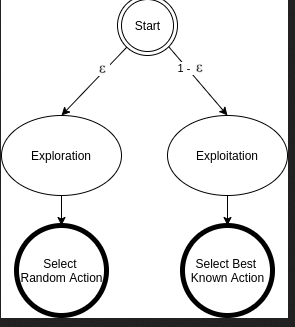


In [ ]:
import argparse
import math
import os
import torch
import random
import torch.nn as nn
from model import DeepQNetwork
from main import SpaceDodgerGame
import torch.optim as optim
from collections import namedtuple, deque
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

# Einrichten von matplotlib für die Visualisierung während des Trainings
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

steps_done = 0
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

Als nächstes wird die Replay Memory Klasse implementiert. Die grundsätzliche Idee hierbeu ist es, Erfahrungen des Agenten zu speichern (als bereits beschriebenes "Transition"-Tuple) und diese später wieder zu verwenden.

Die Klasse nutzt eine Datenstruktur namens "deque", um die Erfahrungen zu speichern. Dieser Speicher hat eine festgelegte maximale Kapazität, und sobald diese Kapazität erreicht ist, werden die ältesten gespeicherten Erfahrungen automatisch entfernt, um Platz für neue zu machen (*maxlen=capacity*).

Die Hauptfunktionen des Replay Memory sind das Hinzufügen neuer Erfahrungen und das Bereitstellen von Stichproben dieser Erfahrungen für das Training des DQN. Neue Erfahrungen werden durch die Methode "push" hinzugefügt. Wie bereits erläutert wird jede Erfahrung als ein Transition-Objekt gespeichert, das Informationen über den aktuellen Zustand, die ausgeführte Aktion, den darauffolgenden Zustand und die erhaltene Belohnung enthält. Das Bereitstellen der Stichprobe erfolgt über die "sample"-Funktion.

Ein signifikanter Vorteil des Replay Memory liegt in der Entkopplung der Erfahrungen. Indem aus einer zufälligen Stichprobe von Erfahrungen gelernt wird, reduziert das Replay Memory die Korrelationen zwischen aufeinanderfolgenden Lernschritten. Diese Korrelationen können problematisch sein, da sie zu einer Verzerrung des Lernprozesses führen und das Netzwerk daran hindern können, eine generalisierte Strategie zu entwickeln.

Ein weiterer Vorteil des Replay Memory ist, dass es den Lernprozess stabilisiert. Da die Erfahrungen über viele verschiedene Zustände und Situationen verteilt sind, verhindert das Replay Memory, dass das Netzwerk zu stark von den jüngsten oder häufigsten Erfahrungen beeinflusst wird. Stattdessen lernt das Netzwerk aus einer breiten Palette von Erfahrungen, was zu einer stabileren und robusteren Lernstrategie führt. Der folgende Code zeigt die Implementierung der ReplayMemory-Klasse.

In [ ]:
class ReplayMemory(object):
    """
    Eine Klasse, die das Replay-Memory für das Deep Q-Learning implementiert.
    Sie speichert Erfahrungen des Agenten, um das Lernen zu stabilisieren und zu verbessern.
    """

    def __init__(self, capacity):
        """Konstruktor der Klasse."""
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Fügt eine Erfahrung zur Speicher hinzu."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Zufällige Stichprobe von Erfahrungen aus dem Speicher."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Gibt die aktuelle Anzahl von Erfahrungen im Speicher zurück (debug)."""
        return len(self.memory)

Um die Möglichkeit zu bieten das Training zu unterbrechen und zu einem späteren Zeitpunkt fortzusetzen (z.B. bei einem lokalen Training über mehrere tausend Episoden hinweg) wird eine "save_checkpoint"-Funktion implementiert, die den aktuellen Stand des Modells nach jeweils 100 Episoden als "state dictionary" speichert.

In [ ]:
def save_checkpoint(model, optimizer, episode, memory, path, steps_done):
    """Erstellt alle 100 Episoden einen Checkpoint, um das Training pickeln zu können."""

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode,
        'replay_memory': list(memory.memory),
        'steps_done': steps_done
    }
    torch.save(checkpoint, path)

Wie bereits erwähnt, sollen sämtliche Hyperparameter optional auch bei einem Aufruf per Kommandozeile übergeben werden können. Dafür werden sie über die Funktion "get_args" initialisiert. Die Bedeutung der einzelnen Parameter wird zu einem späteren Zeitpunkt dieser Arbeit noch erläutert.

In [ ]:
def get_args():
    """Operatoren durch die das Training verändert werden kann bei Aufruf per Kommandozeile"""

    parser = argparse.ArgumentParser("""Deep Q Network for SpaceDodger Game""")
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--learning_rate", type=float, default=1e-4)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--epsilon_start", type=float, default=0.9)
    parser.add_argument("--epsilon_end", type=float, default=0.05)
    parser.add_argument("--epsilon_decay", type=int, default=500000)
    parser.add_argument("--num_episodes", type=int, default=1200)
    parser.add_argument("--replay_memory_size", type=int, default=200000)
    parser.add_argument("--log_path", type=str, default="tensorboard")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    parser.add_argument("--tau", type=float, default=0.010)
    args = parser.parse_args()
    return args

Um während des Trainings auch ohne ein gerendertes Bild (zur Vermeidung von zu hoher Auslastung) ein Feedback über die Trainingsperformance zu erhalten, wird noch eine Funktion "plot_durations" zur Befüllung des Plots implementiert.Diese zeichnet die Überlebensdauer, ausgedrückt über die Variable "episode_duration", auf der Y-Achse auf und zeigt die Anzahl der durchlaufenen Trainingsepisoden auf der X-Achse. Zusätzlich wird alle 100 Episoden der Median der Performance über diese 100 Episoden hinweg aufgezeichnet. Das Plotten geschieht immer nach einer Kollision.

In [ ]:
episode_durations = []

def plot_durations(show_result=False):
    """Erstellt den Matplot während des Trainings um die Performance zu tracken"""

    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Ergebnis')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Dauer')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

        else:
            display.display(plt.gcf())

Die nächste Funktion "select_action" spielt eine wesentliche Rolle bei der Entscheidungsfindung des Agenten. Hier wird die bereits bekannte Epsilon-Greedy-Strategie angewendet, um zwischen Erkundung und Ausbeutung zu balancieren. Die Funktion erhält die folgenden vier Parameter:

<br>

1.   state: der aktuelle Zustand der Umgebung, repräsentiert als Tensor.
2.   model: das DQN-Modell zur Vorhersage der Q-Werte
3.   opt:   für die Übergabe der relevanten Parameter aus argparse.
4.   device: das ausführende Gerät (CPU/GPU) für die Berechnung.

<br>


In der Epsilon-Greedy-Strategie wird der Wert von Epsilon über die Zeit verringert, um den Übergang von Exploration zu Exploitation zu steuern. Dies wird durch eine Formel erreicht, die Epsilon in Abhängigkeit von der Anzahl der bereits durchgeführten Schritte (steps_done) reduziert. Im Code wird dies durch folgende Zeile realisiert:


In [ ]:
eps_threshold = opt.epsilon_end + (opt.epsilon_start - opt.epsilon_end) * \
                math.exp(-1. * steps_done / opt.epsilon_decay)

Hierbei sind "opt.epsilon_start" und "opt.epsilon_end" die per argparse übergebenen Start- und Endwerte von Epsilon (Im Standard 0.9 bzw. 0.05). Der Reduktionsfaktor "opt.epsilon_decay" (im Standard 500000) bestimmt, wie schnell Epsilon abnimmt. Der Faktor wurde so gewählt, dass das Training über 1200 Episoden hinweg mit einem Epsilon-Endwert nahe 0.05 bzw. 5 Prozent endet.

Die Funktion *math.exp(-1 * steps_done / opt.epsilon_decay)* erzeugt einen exponentiellen Abfall von Epsilon. Zu Beginn des Trainings, wenn steps_done klein ist, ist der Wert von "eps_threshold" nahe am Startwert "opt.epsilon_start". Mit zunehmender Anzahl an Schritten nähert sich "eps_threshold" langsam dem Endwert "opt.epsilon_end". Die Unterscheidung zwischen Exploration und Exploitation wird durch einen Vergleich einer zufällig generierten Zahl mit dem berechneten "eps_threshold" getroffen.

Wenn die zufällig generierte Zahl ("sample") kleiner oder gleich "eps_threshold" ist, wählt die Funktion eine zufällige Aktion aus *(return torch.tensor([[random.randrange(2)]])*. Dies fördert die Erkundung, da der Agent Aktionen ausprobiert, die nicht unbedingt als die besten bekannt sind, wodurch er neue Strategien entdecken kann.

Wenn "sample" größer als "eps_threshold" ist, verwendet die Funktion das DQN-Modell *(model(state).max(1).indices.view(1, 1))*, um die Aktion mit dem höchsten Q-Wert für den aktuellen Zustand auszuwählen. Dies stellt die Ausnutzung des bisher erlernten Wissens dar, da der Agent die Aktion wählt, von der das DQN glaubt, dass sie die beste ist. Im Plot sollte dann ersichtlich sein, dass bei sinkendem Epsilon-Wert die Performance im Durchschnitt steigt. Ist dies nicht der Fall, deutet das auf eine nicht-optimale Strategie hin, die das DQN gelernt hat. Die "select_action"-Funktion wird hier nochmal vollständig gezeigt.

In [ ]:
def select_action(state, model, opt, device):
    """
    Wählt eine Aktion basierend auf dem aktuellen Zustand und dem Epsilon-Greedy-Algorithmus aus.

    Parameter:
    - state: Der aktuelle Zustand der Umgebung, ein Tensor.
    - model: Das trainierte Modell (Deep Q-Network).
    - opt: Eine Instanz der Argument-Parser-Klasse mit den Hyperparametern des Modells.
    - device: Das Gerät (CPU oder CUDA), auf dem das Modell läuft.

    Die Funktion wählt eine Aktion entweder zufällig (um Erkundung zu fördern) oder basierend auf der Vorhersage des Modells (um Ausbeutung zu nutzen).
    """

    global steps_done
    sample = random.random()
    # Berechnung des Epsilon-Wertes für die Epsilon-Greedy-Strategie
    eps_threshold = opt.epsilon_end + (opt.epsilon_start - opt.epsilon_end) * \
                    math.exp(-1. * steps_done / opt.epsilon_decay)
    steps_done += 1
    if sample > eps_threshold:
        # Wählt die beste Aktion basierend auf dem Modell (Ausbeutung)
        with torch.no_grad():
            return model(state).max(1).indices.view(1, 1)
    else:
        # Wählt eine zufällige Aktion (Erkundung)
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

Die zweite zentrale Funktion des Trainings ist die "optimize_model" Funktion. Diese führt aus einer Stichprobe des Replay-Memories jeweils einen einzelnen Schritt der Optimierung durch, indem sie den Verlust (oder Fehler) zwischen den vorhergesagten und den gewünschten Q-Werten minimiert.

Zuerst zieht die Funktion eine zufällige Stichprobe von Erfahrungen aus dem Replay Memory. Es müssen mindestens 64 Erfahrung gespeichert sein, sonst steigt die Funktion an der Stelle aus (Bestimmung über das Argument "batch_size", welches mit 64 im Standard gewählt wird).

Wie bereits beschrieben besteht jede gespeicherte Erfahrung aus einem Zustand (s), einer Aktion (a), dem darauffolgenden Zustand (s') sowie einer Belohnung. Die Erfahrungen in der Stichprobe werden in einzelne Tensoren für Zustände, Aktionen, nachfolgende Zustände und Belohnungen aufgeteilt und dann zu jeweils einem Tensor zusammengefasst.

Die Optimierungsfunktion berechnet dann zwei Werte [19]:

<br>

1. Q(st, at): Dies ist der vorhergesagte Q-Wert für den aktuellen Zustand und die ausgeführte Aktion. Es repräsentiert, wie "gut" oder wertvoll es ist, diese Aktion im gegebenen Zustand auszuführen.
2. V(st+1): Dies ist der Wert des bestmöglichen zukünftigen Zustands, der als maximaler Q-Wert für den nächsten Zustand berechnet wird.



Für die Berechnung von Q(st,at) wird das aktuelle Modell ("model") verwendet, um die Q-Werte für alle möglichen Aktionen im aktuellen Zustandsbatch ("state_batch") zu berechnen. Die Methode *.gather(1, action_batch)* wählt dann aus diesen Q-Werten jene aus, die den im aktuellen Batch ausgeführten Aktionen ("action_batch") entsprechen. Dies ergibt die vorhergesagten Q-Werte für die Kombinationen von Zuständen und Aktionen, die in der Stichprobe enthalten sind. Der Codeausschnitt aus der "optimize_model"-Funktion ist der nachfolgende.

In [ ]:
state_action_values = model(state_batch).gather(1, action_batch)

Für die Berechnung von V(st+1), dem Wert des bestmöglichen zukünftigen Zustands, wird zuerst ein Tensor "next_state_values" mit Nullwerten initialisiert. Die Länge dieses Tensors entspricht der Batch-Größe. Die Nullen repräsentieren die Werte für die Zustände, in denen das Spiel endet (da es keine zukünftigen Belohnungen gibt).

Dann wird das Zielnetzwerk ("target_model") verwendet, um die Q-Werte für die nächsten Zustände zu berechnen. Der Ausdruck *.max(1).values* wählt den maximalen Q-Wert aus diesen Vorhersagen für jeden Zustand aus. Das bedeutet, es wird der beste erwartete Wert für den nächsten Zustand ausgewählt, was V(st+1) entspricht. Diese Werte werden dann in next_state_values eingefügt, aber nur für die Zustände, die nicht das Spielende darstellen ("non_final_mask").

In [ ]:
next_state_values = torch.zeros(opt.batch_size, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_model(non_final_next_states).max(1).values

Der Verlust wird als Differenz zwischen diesen beiden Werten berechnet. Wenn der aktuelle Zustand ein Endzustand ist (das Spiel ist beendet), wird der Wert des nächsten Zustands als null angenommen (V(s) = 0), da es keine zukünftigen Belohnungen gibt.

Nach der Berechnung des Verlustes aktualisiert die Funktion die Gewichte des neuronalen Netzwerks, um diesen Verlust zu minimieren (*optimizer.zero_grad()*). Dieser Prozess, bekannt als Backpropagation, passt die Gewichte so an, dass das Netzwerk im Laufe der Zeit genauere Vorhersagen über die Q-Werte trifft. Dadurch lernt das DQN, bessere Entscheidungen zu treffen, um maximale Belohnungen zu erzielen. Zuletzt findet auch ein Gradientclipping statt, um Extremwerte zu vermeiden. Die gesamte "optimize_model"-Funktion ist nachfolgend dargestellt.

In [ ]:
def optimize_model(opt, memory, model, target_model, optimizer, criterion, device):
    """
    Führt eine Optimierungsschritt für das Modell durch, basierend auf einer Stichprobe aus dem Replay Memory.

    Parameter:
    - opt: Eine Instanz der Argument-Parser-Klasse mit den Hyperparametern des Modells.
    - memory: Das Replay Memory, aus dem Erfahrungen gezogen werden.
    - model: Das aktuelle Modell (Deep Q-Network), das trainiert wird.
    - target_model: Ein separater Ziel-Netzwerk, das zur Stabilisierung des Lernens verwendet wird.
    - optimizer: Der Optimierer für das Modell.
    - criterion: Das Verlustfunktionskriterium.
    - device: Das Gerät (CPU oder CUDA), auf dem das Modell läuft.

    Diese Funktion aktualisiert das Modell basierend auf einer Stichprobe von Erfahrungen, um das Verlustkriterium zu minimieren.
    """

    if len(memory) < opt.batch_size:
        # Nicht genug Erfahrungen im Memory, um eine Stichprobe zu ziehen .. beenden
        return
    transitions = memory.sample(opt.batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    # Trennt die gesammelten Erfahrungen in ihre Bestandteile
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Berechnet den Q-Wert für die aktuellen Zustände und Aktionen
    state_action_values = model(state_batch).gather(1, action_batch)
    # Berechnet den erwarteten Q-Wert der nächsten Zustände
    next_state_values = torch.zeros(opt.batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_model(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * opt.gamma) + reward_batch
    # Berechnet den Verlust zwischen den berechneten Q-Werten und den erwarteten Q-Werten
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Führt den Optimierungsschritt durch
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(model.parameters(), 100)
    optimizer.step()

    return loss.item()

Die zuvor beschriebenen Funktionen zur Auswahl einer Aktion und zur Optimierung werden im Rahmen der nun folgenden Trainingsfunktion aufgerufen.

Zuerst werden die notwendigen Komponenten für das Training initialisiert. Dazu gehören das Haupt-DQN-Modell, ein separates Zielmodell (Target Model), das Replay Memory, der Optimierer und die Verlustfunktion. Diese Initialisierung umfasst auch die Festlegung der Lernrate und anderer wichtiger Hyperparameter wie der Größe des Replay Memory.

Im Code wird die Ausführungsumgebung für das Training bestimmt, welches abhängig von der Verfügbarkeit auf einer CPU oder einer GPU (CUDA) stattfindet.

Danach werden die Eingabe- und Ausgabeparameter an das DQN übergeben. Die Anzahl für den Eingabeparameter entspricht der Anzahl der Informationen, die in der "get_state" - Funktion aus dem "main.py" Skript übergeben wird (in diesem Fall fünf). Die Anzahl der Ausgabeparameter entspricht der Anzahl an Aktionen aus der "select_action"-Funktion aus dem "main.py" Skript (in diesem dargestellten Fall zwei Aktionen).

Außerdem wird die Verlustfunktion ("criterion") über den Mean Squared Error (MSE) definiert, um den Unterschied zwischen den vorhergesagten Q-Werten des und den Ziel-Q-Werten zu berechnen. Die Verlustfunktion liefert eine quantitative Bewertung, wie gut oder schlecht das Modell in seiner aktuellen Konfiguration funktioniert. Ein hoher Verlust weist darauf hin, dass das Modell die Q-Werte nicht genau vorhersagt, während ein niedriger Verlust anzeigt, dass das Modell die Realität gut abbildet.

Die Anpassung der Gewichtung des DQN kommt über den Optimierer zustande. Dieser verwendet die Informationen aus der Verlustfunktion und leitet darauf basierend ab, in welche Richtung die Gewichte des Modells angepasst werden müssen, um den Verlust in zukünftigen Prognosen zu minimieren. Der hier beschriebene Ausschnitt aus der Trainingsfunktion ist im folgenden Codeblock zu sehen.






In [ ]:
def train(opt):
    """
    Haupttrainingsfunktion. Setzt das Training des Deep-Q-Networks mit dem SpaceDodger-Spiel als Umgebung auf.
    """

    # ... Initialisierung von Modellen, Optimierer, Kriterium, Memory ...
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = 5 # Anzahl der Parameter die in get_state aus main.py übergeben werden
    output_size = 2 # Anzahl der Aktionne (links rechts)

    writer = SummaryWriter(log_dir=opt.log_path)
    model = DeepQNetwork(input_size, output_size).to(device)
    target_model = DeepQNetwork(input_size, output_size).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.AdamW(model.parameters(), lr=opt.learning_rate, amsgrad=True)
    criterion = nn.MSELoss()
    memory = ReplayMemory(opt.replay_memory_size)
    start_episode = 0

Bevor die Trainingsschleife startet gibt es noch einen kleinen Einschub, um ggf. existierende gespeicherte und nicht abgeschlossene Trainingsmodelle zu laden. Der checkpoint_path muss noch um die Episode angepasst werden, zu der das Modell gespeichert worden ist (d.h. z.B. space_dodger_checkpoint_1200.pth).

In [ ]:
    checkpoint_path = f"{opt.saved_path}/space_dodger_checkpoint.pth"  # zahl noch dahinter
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode']
        global steps_done
        steps_done = checkpoint.get('steps_done', 0)
        loaded_memory = checkpoint.get('replay_memory', [])
        for item in loaded_memory:
            memory.push(*item)

Der Trainingsprozess wird über die folgende Schleife initialisiert, wobei *opt.num_episodes* ein frei gewählter Parameter ist, der in der argparse-Funktion festgelegt wurde. Eine höhere Anzahl von Episoden kann für das Training förderlich sein, erfordert aber ggf. auch eine Anpassung des Epsilons und der Lernrate. Mehr Episoden ermöglichen es dem Agenten, die Umgebung gründlicher zu erkunden. Dies ist besonders wichtig in komplexen oder stark variierenden Umgebungen, wo der Agent viele unterschiedliche Szenarien erleben muss, um effektiv zu lernen. In der Konsequenz erhält das DQN robustere Lernergebnisse, da ein breites Spektrum an Erfahrungen gesammelt werden kann. Andererseits bedingen mehr Episoden längere Trainingszeiten und bergen das Risiko von Overfitting. Hier ist der Agent zu stark auf spezifische Szenarien konzentriert und verliert die Fähigkeit, in veränderten Umgebungen gut zu funktionieren.
In dieser Ausarbeitung wurde sich nach mehreren Versuchen in einer Range von 100 und 6000 Episoden für eine Laufzeit von 1200 Episoden entschieden. Wesentlich mehr Episoden haben keine signifikante Leistungsverbesserung mehr gezeigt.

Jede Episode beginnt mit einem Anfangszustand des Spiels, welches aus der "get_state"-Funktion der Umgebung ("main.py") extrahiert wird und dann in einen Tensor umgewandelt wird.

In [ ]:
    for episode in range(start_episode, opt.num_episodes):
        env = SpaceDodgerGame()  # Initialisierung der Spielumgebung
        state = env.get_state() # Anfangszustand der Umgebung
        state_tensor = torch.tensor([state], dtype=torch.float).to(device) # Umwandlung in Tensor

Der tatsächliche Trainingprozess findet dann in der nachfolgenden, innenliegenden Schleife statt. Statt der count()-Methode aus dem Paket "itertools" hätte auch eine normale "while"-Schleife genutzt werden können, dann hätte jedoch noch eine Variable hochgezählt werden müssen, um die Episodenlänge ("episode_durations") für den Plot zu tracken.

Jede Iteration in dieser Schleife repräsentiert einen Schritt innerhalb einer einzelnen Episode des Spiels. Zu Beginn jedes Schritts wählt das DQN-Modell eine Aktion basierend auf dem aktuellen Zustand des Spiels. Dies erfolgt durch die bereits vorgestellte Funktion select_action, die die Epsilon-Greedy-Strategie verwendet.

Die ausgewählte Aktion wird dann in der Spielumgebung angewendet ("env.step(action.item()"). Dies führt zur Änderung des Spielzustands und liefert eine Belohnung und eine Information darüber, ob das Spiel beendet ist (in der vorliegenden Ausarbeitung nur durch Kollision möglich).

Der aktuelle Zustand, die ausgeführte Aktion, der resultierende neue Zustand und die erhaltene Belohnung werden als Erfahrung im Replay Memory gespeichert ("memory.push()"). Dieser Schritt ist wichtig, um später aus einer Stichprobe von Erfahrungen lernen zu können. Anschließend wird die Funktion "optimize_model" aufgerufen, um den Verlust zwischen den vorhergesagten Q-Werten und den Ziel-Q-Werten zu berechnen bzw. um die Gewichte des Modells entsprechend anzupassen.

Periodisch wird das Zielnetzwerk (Target Model) über den Parameter "tau" aktualisiert. Dies ist dann eine sogenannte  "weiche Aktualisierung", bei der die Gewichte des Zielnetzwerks langsam an die des Hauptmodells angeglichen werden. Im Gegensatz zu einer "harten Aktualisierung", die z.B. alle 10 Episoden stattfindet, kann hier die Stabilität des Lernprozesses erhöht werden.

Wenn der Zustand "done" wahr ist, was bedeutet, dass das Spiel beendet ist (durch eine Kollision), endet die aktuelle Episode über einen Break. Damit steigt der Code aus der innenliegenden Schleife aus,protokolliert die Dauer der Episode und ruft den Plot auf. Anschließend beginnt die nächste Episode. Dieser Codeausschnitt ist nachfolgend zu sehen.

In [ ]:
        # Schleife für jeden Schritt innerhalb einer Episode
        for t in count():
            # ... Verarbeitung des nächsten Zustands, Belohnung und Aktualisierung des Modells ...
            action = select_action(state_tensor, model, opt, device)
            next_state, reward, done = env.step(action.item())
            next_state_tensor = None if done else torch.tensor([next_state], dtype=torch.float).to(device)
            reward_tensor = torch.tensor([reward], dtype=torch.float).to(device)

            memory.push(state_tensor, action, next_state_tensor, reward_tensor)
            state_tensor = next_state_tensor

            # Optimize model
            loss = optimize_model(opt, memory, model, target_model, optimizer, criterion, device)

            if loss is not None:
                total_loss += loss

            total_reward += reward

            # Update target network
            target_net_state_dict = target_model.state_dict()
            policy_net_state_dict = model.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * opt.tau + target_net_state_dict[key] * (
                            1 - opt.tau)
            target_model.load_state_dict(target_net_state_dict)

            if done:
                # Verarbeiten des Episodenendes bei Kollision
                episode_durations.append(t + 1)
                plot_durations()
                break

Der Vollständigkeit halber wird auch noch auf den Schlussteil der Funktion eingengangen. Die erneute Bestimmung der Epsilon-Rate wird hier lediglich für das Tracking in tensorboardX vorgenommen (siehe writer.add).

Die Zeilen *env.render* und *env.update_spaceship_animation()* sind optional und ermöglichen das Zeichnen des Spiels in das Pygame-Fenster. Das kann hilfreich sein, um den Agenten tatsächlich auch spielen zu sehen und die ausgewählten Aktionen genauer zu tracken.

Alle 100 Episoden (ausgenommen bei der ersten) wird ein Checkpoint gespeichert, dessen Existenz vor Beginn des Trainings im Code abgefragt wird. Nach der letzten Episode und somit nach dem Beenden der äußeren Schleife wird das finale Modell gespeichert. Das Training ist dann beendet. Der Abschluss des Trainingscodes ist im folgenden Block festgehalten.

In [ ]:
            eps_rate = opt.epsilon_end + (opt.epsilon_start - opt.epsilon_end) * math.exp(
                -1. * steps_done / opt.epsilon_decay)

            env.render(action=action) # Kann auskommentiert werden, falls man den Agenten nicht spielen sehen will
            env.update_spaceship_animation() # ist nur die Spaceship-Animiation
            print(
                f"Episode: {episode + 1}/{opt.num_episodes}, Iteration: {steps_done}, Level: {env.current_level}, Epsilon: {eps_rate:.4f}")

        # Bestimmte Skalarae Werte sollen dauerhaft geloggt werden
        average_loss = total_loss / (t + 1)
        writer.add_scalar('Episode_duration', t + 1, episode)
        writer.add_scalar('Epsilon_rate', eps_rate, episode)
        writer.add_scalar('Average_loss', average_loss, episode)
        writer.add_scalar('Total_reward', total_reward, episode)

        # Häufigkeit des Loggings tracken., damit nicht jede EPisode getrackt wird
        if episode % log_interval == 0:
            for name, param in model.named_parameters():
                writer.add_histogram(f'Episode_{episode}/{name}_grad', param.grad, episode)
                writer.add_histogram(f'Episode_{episode}/{name}_weight', param, episode)

        # Save checkpoint
        if episode % 100 == 0 and episode != 0:
            save_checkpoint_path = f"{opt.saved_path}/space_dodger_checkpoint_{episode}.pth"
            save_checkpoint(model, optimizer, episode, memory, save_checkpoint_path, steps_done)


    # Abschließende Schritte nach dem Training, Speichern des fertigen Modells und Tensorboards
    torch.save(model.state_dict(), f"{opt.saved_path}/space_dodger_final.pth")

    writer.close()
    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    opt = get_args()
    train(opt)

<a name="test"></a>
## 8. Evaluation und Test

Der nachfolgende Plot ist das Ergebnis nach 1200 durchlaufenen Perioden, mit den unter der Funktion "argparse" definierten Hyperparametern. Es ist gut ersichtlich, dass gerade in der frühen Phase eine große Varianz innerhalb der einzelnen Episoden (grüne Balken) bestanden hat. Das ist durch die starke anfängliche Exploration des Agenten bedingt.
Die rote Linie, welche den gleitenden Durchschnitt über alle 100 Episoden anzeigt, lässt einen aufwärts gerichteten Trend erkennen. Das deutet darauf hin, dass die Leistung des Agenten im Laufe der Zeit verbessert wird, da er lernt, Aktionen auszuführen, die die Episode verlängern.

Trotz des allgemein positiven Trends gibt es aber auch in den späten Episoden eine hohe Varianz in der Leistung, die darauf hinweist, dass der Agent ggf. im Rahmen der Exploration nicht die optimale Politik gefunden hat. Der Grund dafür widerrum kann in suboptimal gesetzten Parametern (zu langsame/schnelle Lernrate, zu langsamer/schneller Epsilonverfall) liegen, oder auf eine grundsätzliche Unzulänglichkeit im DQN (nicht komplex genug, suboptimale Netzwerkart) zurückzuführen sein. Denkbar ist auch, dass die Art des Belohnungssystems, oder die Anzahl der an das DQN übergebenen Statusparameter nicht ausgereift genug waren.

Am Ende scheint es im Plot auch eine Art Plateau (mit Leistungsabfall) zu geben, was möglicherweise auf eine Leistungsgrenze des Agenten hinweist.

Diese Grenze hängt potentiell auch mit dem Design des Spiels selbst zusammen - da die Asteroiden immer schneller werden, das Raumschiff aber nicht, gibt es natürlicherweise an einer bestimmten Stelle (üblicherweise Level 30+) immer eine Kollision.

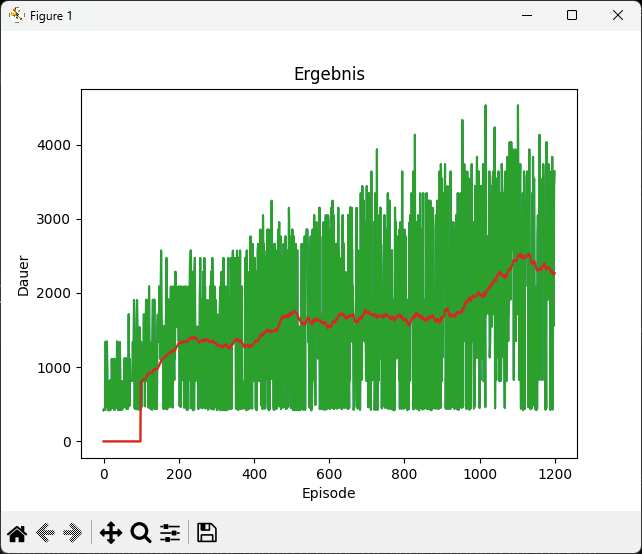

Um das gespeicherte, über 1200 Episoden trainierte Modell jederzeit testen zu können, wird abschließend noch das fünfte Skript "test.py" implementiert.

Im Rahmen der Initialisierung werden wieder die notwendigen Pakete geladen und die Standardargumente definiert. In diesem Fall sind es die folgenden zwei:



*   der Pfad des gespeicherten Modells
*   die Anzahl der Episoden, über die das Modell getestet werden soll.




In [ ]:
import argparse
import torch
from main import SpaceDodgerGame
import pygame
from model import DeepQNetwork
import os

def get_args():
    """
    Definiert und holt die Befehlszeilenargumente für das Testskript.
    --saved_path: Pfad zum Verzeichnis, in dem das trainierte Modell gespeichert ist.
    --num_episodes: Anzahl der Episoden, über die das Modell getestet wird.
    """
    parser = argparse.ArgumentParser("""Testet das Deep Q Network im SpaceDodger-Spiel""")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    parser.add_argument("--num_episodes", type=int, default=10)  # Standardmäßig 10 Episoden
    args = parser.parse_args()
    return args

Daraufhin folgt die eigentliche Testfunktion, welche zu Beginn wie beim Training die Input- und Outputparameter definiert, das Gerät für die Kalkulation wählt und das gespeicherte Modell einlädt.

Die Zeile *model.eval()*, versetzt das Modell in einen Zustand, der konsistente, von Trainingsvariablen unabhängige Vorhersagen liefert, was die Bewertung der Modellperformance robuster macht.

Aufgrund des gewählten DQN der vorliegenden Arbeit ist die Zeile eher optionaler Natur, da wir weder Dropout-Layer haben, noch eine Batch-Normalization betreiben. Stattdessen wurde hier mit vollständig verbundenen Schichten ("nn.Linear") gearbeitet, die keinen unterschiedlichen Modus für Test und Training benötigen.

Die Funktion durchläuft dann die Anzahl von Episoden, die durch *opt.num_episodes *festgelegt worden ist. Für jede Episode wird eine neue Instanz des Spiels erstellt und das Spiel wird auf den Anfangszustand zurückgesetzt.

Innerhalb der inneren Schleife (diesmal eine "While"-Schleife) wird der aktuelle Zustand des Spiels genommen, um mit dem Modell die beste Aktion vorherzusagen. Dies geschieht unter Verwendung von torch.no_grad(), was bedeutet, dass keine Gradienten berechnet werden, da das Modell nicht weiter trainiert, sondern nur evaluiert wird.

Die vorhergesagte Aktion wird dann im Spiel ausgeführt ("game.step(action)"), was den Spielzustand aktualisiert und Informationen darüber liefert, ob das Spiel beendet ist.

In [ ]:
def test(opt):
    """
    Testet das trainierte Deep Q-Network-Modell im SpaceDodger-Spiel mit der definierten ANzahl Episoden
    """
    input_size = 5  # Größe des Eingabevektors
    output_size = 2  # Größe des Ausgabevektors

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepQNetwork(input_size, output_size).to(device)

    model_path = f"{opt.saved_path}/space_dodger_final.pth"
    if os.path.exists(model_path):
        model_state = torch.load(model_path, map_location=device)
        model.load_state_dict(model_state)
        print("Modellgewichte erfolgreich geladen.")
    else:
        print("Kein gespeichertes Modell gefunden. Bitte überprüfen Sie den Pfad.")
        return

    model.eval()  # Modell in den Evaluierungsmodus setzen

    for episode in range(opt.num_episodes):  # Schleife über die gewünschte Anzahl an Episoden
        game = SpaceDodgerGame()  # Erstellt eine neue Instanz des Spiels
        state = game.reset()  # Setzt das Spiel zurück und erhält den Anfangszustand

        while True:
            state_tensor = torch.tensor([state], dtype=torch.float).to(device)
            with torch.no_grad():
                prediction = model(state_tensor)
            action = torch.argmax(prediction).item()

            next_state, _, done = game.step(action)  # Führt die gewählte Aktion im Spiel aus

            state = next_state

            pygame.display.flip()  # Aktualisiert das Spiel-Display
            game.render(action)  # Zeichnet das Spiel mit der gewählten Aktion

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            if done:  # Überprüft, ob die Episode beendet ist
                break

        print(f"Episode {episode + 1} abgeschlossen.")

if __name__ == "__main__":
    opt = get_args()
    test(opt)


<a name="fazit"></a>
## 9. Fazit

In der vorliegenden Hausarbeit wurde das Spiel "SpaceDodger" als Testumgebung für die Anwendung von Reinforcement Learning (RL) mit einem Deep Q-Network (DQN) als grundlegendes Lernmodell verwendet. Durch die Implementierung und das Training des DQN konnte der Agent erfolgreich lernen, das Spiel zu spielen, indem er eine zielführende (wenn auch nicht perfekte) Strategie zur Steigerung der kumulativen Belohnung durch Interaktion mit der Umgebung erlernte. Die Anwendung von Techniken wie Replay Memory Epsilon-Greedy-Strategie und "soft-Aktualisierung" des Zielnetzwerks trug zur Stabilität des Lernprozesses bei und förderte eine effiziente Exploration des Zustandsraums.

Dennoch gibt es Raum für potentielle Verbesserungen. Das DQN verwendet derzeit  vollständig verbundene Schichten, die zwar eine solide Leistung zeigen, aber möglicherweise nicht die beste Wahl für die Verarbeitung visueller Eingaben sind. Die Nutzung von Convolutional Neural Networks (CNNs) könnte die Fähigkeit des Modells verbessern, wichtige visuelle Merkmale aus den Spielbildern zu extrahieren und zu einer feineren Entscheidungsfindung beitragen. Das zeigen auch vergleichbare Arbeiten, bei denen beispielsweise das Spiel "Flappy Bird" durch ein CNN sehr erfolgreich (wenngleich über eine enorme Anzahl von Episoden) trainiert worden ist. Weiterhin könnte anstelle des "klassischen" Replay Memory auch ein priorisiertes Experience Replay verwendet werden, um dem Agenten zu ermöglichen, von wichtigeren oder selteneren Erfahrungen schneller zu lernen, indem diese Erfahrungen mit höherer Wahrscheinlichkeit erneut abgerufen werden. Um Problemen wie der Überbewertung von Q-Werten entgegenzuwirken, könnten Variationen des DQN wie Double DQN oder Dueling DQN implementiert werden, die eine stabilere und zuverlässigere Schätzung der Q-Werte bieten - oblgeich für diese DQNs vermutlich die Anzahl der Trainingsepisoden stark erhöht werden müsste, bis ein spürbarer Effekt eintritt.

Insgesamt bestätigen die Ergebnisse dieser Ausfertigung das grundlegende Potenzial von DQN im Bereich des Reinforcement Learnings und bieten einen wertvollen Ausgangspunkt für weitere Forschung und Entwicklung. Zukünftige Arbeiten könnten die genannten Verbesserungen untersuchen, um die Grenzen des aktuellen Modells zu erweitern und die Effizienz und Effektivität des Agenten weiter zu steigern.

<a name="literatur"></a>
## 10. Literaturverzeichnis

[1] Pygame Dokumentation, Link: https://www.pygame.org/docs/<br><br>
[2] Pytorch Dokumentation, Link: https://pytorch.org/docs/stable/index.html<br><br>
[3] Pytorch Tutorial, Link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html<br><br>
[4] Vishnu, S., Yogesh, S., Mitchell, L.,*Deep Learning with
PyTorch 1.x*, Seite 228, 2019<br><br>
[5] Odemakinde, E., *Model-Based and Model-Free Reinforcement Learning: Pytennis Case Study*, Link: https://neptune.ai/blog/model-based-and-model-free-reinforcement-learning-pytennis-case-study, 2023<br><br>
[6]  Suran, A., *On-Policy v/s Off-Policy Learning*, Link: https://towardsdatascience.com/on-policy-v-s-off-policy-learning-75089916bc2f, 2020<br><br>
[7] Ebd.<br><br>
[8] Torres, J., *The Bellman Equation
V-function and Q-function Explained*, Link: https://towardsdatascience.com/the-bellman-equation-59258a0d3fa7, 2020<br><br>
[9] Modasara, B., *Reinforcement Learning – Beispiel aus der Praxis und Framework*, Link: https://www.alexanderthamm.com/de/blog/reinforcement-learning-framework-und-anwendungsbeispiel/, 2023<br><br>
[10] Gomede, E., *Deep Q-Networks (DQN): Bridging the Gap between Deep Learning and Reinforcement Learning*, Link: https://medium.com/@evertongomede/deep-q-networks-dqn-bridging-the-gap-between-deep-learning-and-reinforcement-learning-5cd73d644c7, 2013<br><br>
[11] Vishnu, S., Yogesh, S., Mitchell, L.,*Deep Learning with
PyTorch 1.x*, Seite 248, 2019<br><br>
[12] Laskin, M., *Practical tips for training Deep Q Networks*, Link: https://www.anyscale.com/blog/practical-tips-for-training-deep-q-networks, 2022<br><br>
[13] Moghadam, P., *Deep Reinforcement learning: DQN, Double DQN, Dueling DQN, Noisy DQN and DQN with Prioritized Experience Replay*, Link: https://medium.com/@parsa_h_m/deep-reinforcement-learning-dqn-double-dqn-dueling-dqn-noisy-dqn-and-dqn-with-prioritized-551f621a9823, 2019<br><br>
[14] Deeplizard, Link: https://deeplizard.com/learn/video/wrBUkpiRvCA, 2018<br><br>
[15] Ebd.<br><br>
[16] Data Base Camp, *Was ist die ReLU-Funktion (Rectified Linear Unit)?*, Link: https://databasecamp.de/ki/relu#:~:text=Die%20Rectified%20Linear%20Unit%20(ReLU,negative%20Werte%20auf%20Null%20setzt., 2023<br><br>
[17] Baeldung, *Epsilon-Greedy Q-learning*, Link: https://www.baeldung.com/cs/epsilon-greedy-q-learning, 2023<br><br>

## <a name="eigenständigkeitserklärung"></a>
## 11. Eigenständigkeitserklärung

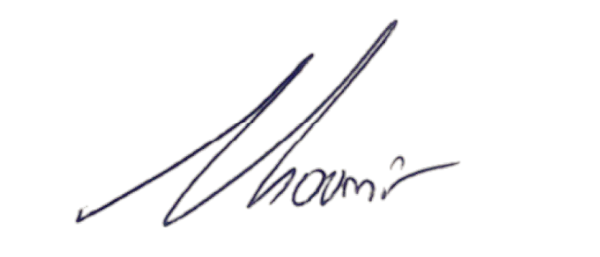

